In [55]:
import boto3
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sagemaker import Session

# # Initialize a SageMaker session
# sagemaker_session = Session()



# role = "arn:aws:iam::016114370410:role/tf-binding-sites"

# prefix = "inference/output/all-train-no-PE-2024-08-05-17-52-07/"
# local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"


# # Initialize the S3 client
# s3 = boto3.client('s3')

# # Specify your S3 bucket name
# bucket_name = sagemaker_session.default_bucket()


# # Function to download files from an S3 bucket
# def download_from_s3(bucket_name, prefix, local_dir):
#     if not os.path.exists(local_dir):
#         os.makedirs(local_dir)

#     # List objects within the specified prefix
#     response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

#     # Iterate over each object
#     for obj in response.get('Contents', []):
#         key = obj['Key']
#         # Skip if it's a folder
#         if key.endswith('/'):
#             continue
#         local_path = os.path.join(local_dir, os.path.basename(key))
        
#         # Download the file
#         s3.download_file(bucket_name, key, local_path)
#         print(f'Downloaded {key} to {local_path}')

# # Bucket name extracted from the S3 URI
# bucket_name = "tf-binding-sites"

# # delete the files in local dir
# for file in os.listdir(local_dir):
#     os.remove(os.path.join(local_dir, file))
    

# # Download the files
# download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")


# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/all_training_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter
0,chr17,68474329,68474711,A549,0,0,0,0.003049,0,0
1,chr17,68474442,68474704,HEK_293,0,0,0,0.000702,0,0
2,chr17,68485145,68486170,THP-1,0,0,0,0.004376,0,0
3,chr17,68485778,68486177,A549,0,0,0,0.005130,0,0
4,chr17,68490815,68492311,A549,0,0,0,0.000397,0,0
...,...,...,...,...,...,...,...,...,...,...
602250,chr6,100080548,100080721,THP-1,0,0,0,0.071128,0,0
602251,chr6,100088028,100088349,LNCAP,0,1,6,0.693787,0,0
602252,chr6,100088048,100088425,PC-3,0,0,0,0.216996,0,0
602253,chr6,100096399,100097117,THP-1,0,0,0,0.000729,0,0


In [56]:
# create correct or incorrect prediction column
df['correct'] = df['predicted'] == df['targets']
df.head()

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter,correct
0,chr17,68474329,68474711,A549,0,0,0,0.003049,0,0,True
1,chr17,68474442,68474704,HEK_293,0,0,0,0.000702,0,0,True
2,chr17,68485145,68486170,THP-1,0,0,0,0.004376,0,0,True
3,chr17,68485778,68486177,A549,0,0,0,0.005130,0,0,True
4,chr17,68490815,68492311,A549,0,0,0,0.000397,0,0,True


In [57]:
# Calculate True and False counts
df['True'] = df['correct'] == True
df['False'] = df['correct'] == False

# Group by weight and cell line
grouped = df.groupby(['weights', 'cell_line']).agg({'True': 'sum', 'False': 'sum'})

# Calculate precision, recall, f1
grouped['precision'] = grouped['True'] / (grouped['True'] + grouped['False'])
grouped['recall'] = grouped['True'] / (grouped['True'] + grouped['False'])  # Assuming this is correct, might need True Positives / Actual Positives
grouped['f1'] = 2 * (grouped['precision'] * grouped['recall']) / (grouped['precision'] + grouped['recall'])
grouped

True  False  precision    recall        f1
weights cell_line                                              
0       A549       131818  13408   0.907675  0.907675  0.907675
        HEK_293     65107    961   0.985454  0.985454  0.985454
        LNCAP       35323    699   0.980595  0.980595  0.980595
        PC-3        61177   6077   0.909641  0.909641  0.909641
        THP-1      163626  32365   0.834865  0.834865  0.834865
...                   ...    ...        ...       ...       ...
113     LNCAP           0      1   0.000000  0.000000       NaN
132     LNCAP           1      0   1.000000  1.000000  1.000000
146     LNCAP           1      0   1.000000  1.000000  1.000000
158     LNCAP           1      0   1.000000  1.000000  1.000000
177     LNCAP           1      0   1.000000  1.000000  1.000000

[115 rows x 5 columns]

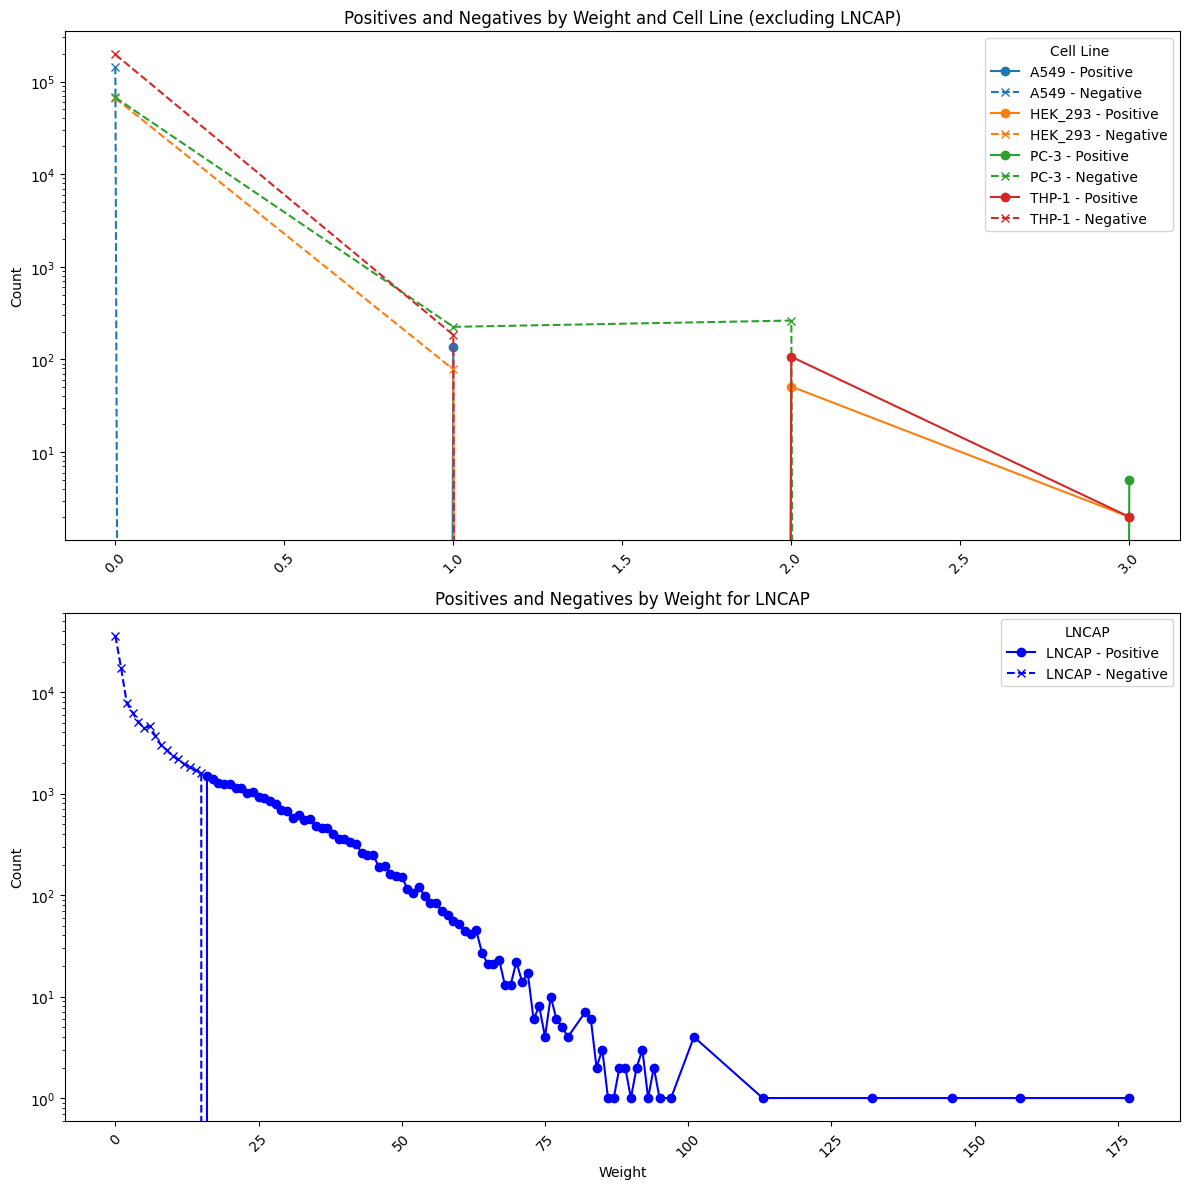

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'targets'
# df = pd.read_csv('your_data.csv')

# Calculate Positives and Negatives
df['Positive'] = (df['targets'] == 1).astype(int)
df['Negative'] = (df['targets'] == 0).astype(int)

# Group by weight and cell line
grouped_pos_neg = df.groupby(['weights', 'cell_line']).agg({'Positive': 'sum', 'Negative': 'sum'})

# Separate LNCAP data
grouped_pos_neg_lncap = grouped_pos_neg.xs('LNCAP', level='cell_line')
grouped_pos_neg_others = grouped_pos_neg.drop('LNCAP', level='cell_line')

# Define line styles
line_styles = {'Positive': '-', 'Negative': '--'}
colors = {}

# Plotting total number of positives and negatives for all cell lines excluding LNCAP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plotting for other cell lines
for i, cell_line in enumerate(grouped_pos_neg_others.index.get_level_values('cell_line').unique()):
    subset = grouped_pos_neg_others.xs(cell_line, level='cell_line')
    color = f'C{i}'  # Use default color cycle
    colors[cell_line] = color
    axes[0].plot(subset.index, subset['Positive'], marker='o', color=color, linestyle=line_styles['Positive'], label=f'{cell_line} - Positive')
    axes[0].plot(subset.index, subset['Negative'], marker='x', color=color, linestyle=line_styles['Negative'], label=f'{cell_line} - Negative')
axes[0].set_title('Positives and Negatives by Weight and Cell Line (excluding LNCAP)')
axes[0].set_ylabel('Count')
axes[0].set_yscale('log')
axes[0].legend(title='Cell Line')

# Plotting for LNCAP
axes[1].plot(grouped_pos_neg_lncap.index, grouped_pos_neg_lncap['Positive'], marker='o', color='blue', linestyle=line_styles['Positive'], label='LNCAP - Positive')
axes[1].plot(grouped_pos_neg_lncap.index, grouped_pos_neg_lncap['Negative'], marker='x', color='blue', linestyle=line_styles['Negative'], label='LNCAP - Negative')
axes[1].set_title('Positives and Negatives by Weight for LNCAP')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Weight')
axes[1].set_yscale('log')
axes[1].legend(title='LNCAP')

# Rotating x-axis labels for better readability
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

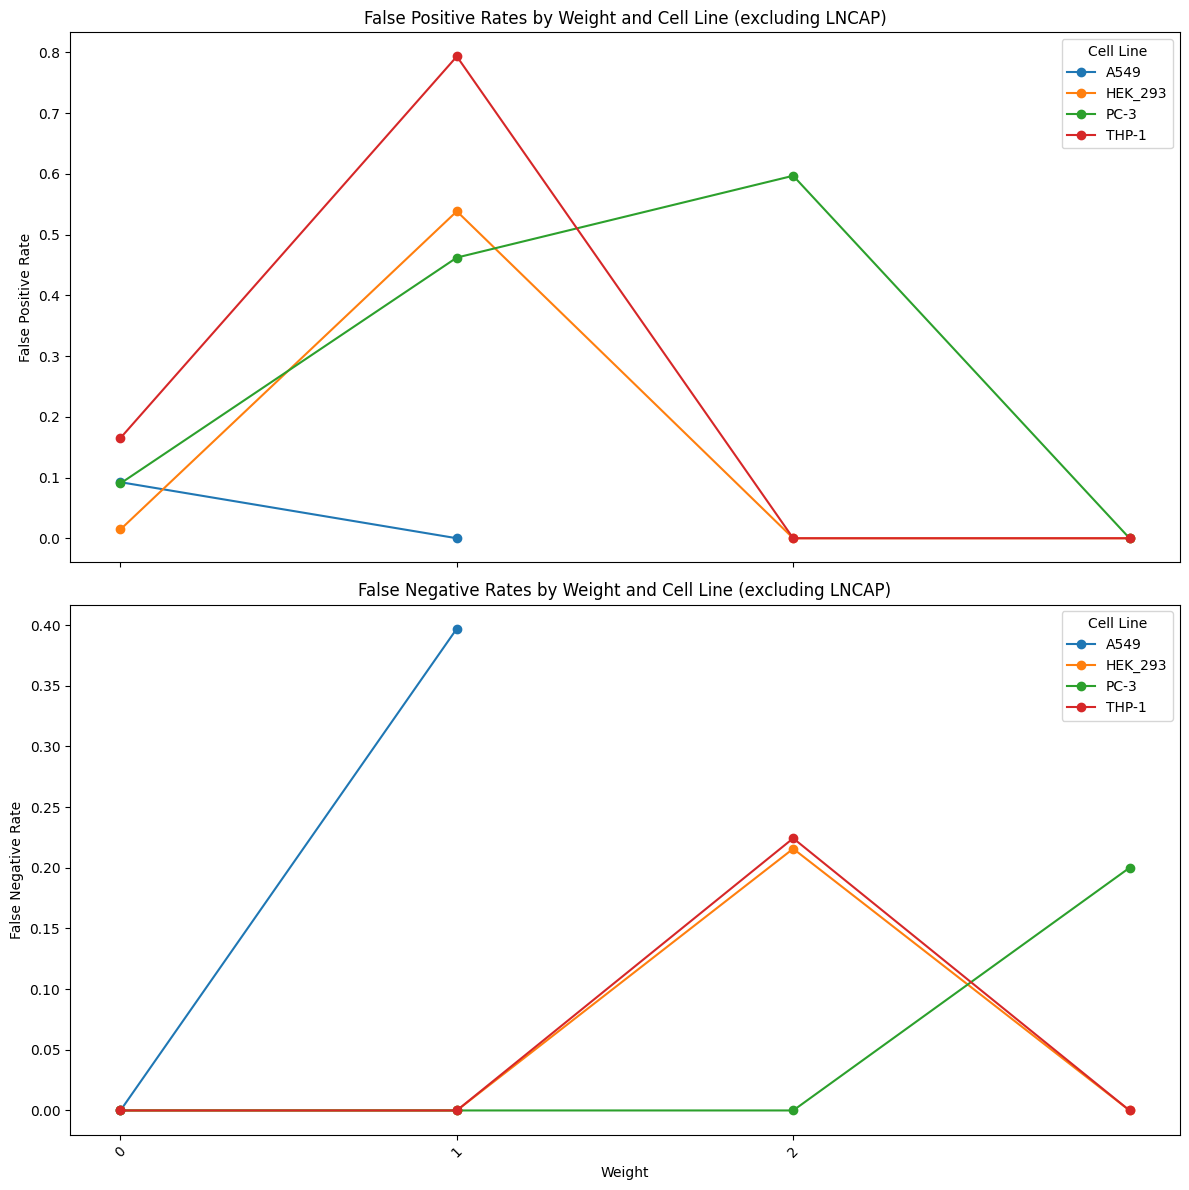

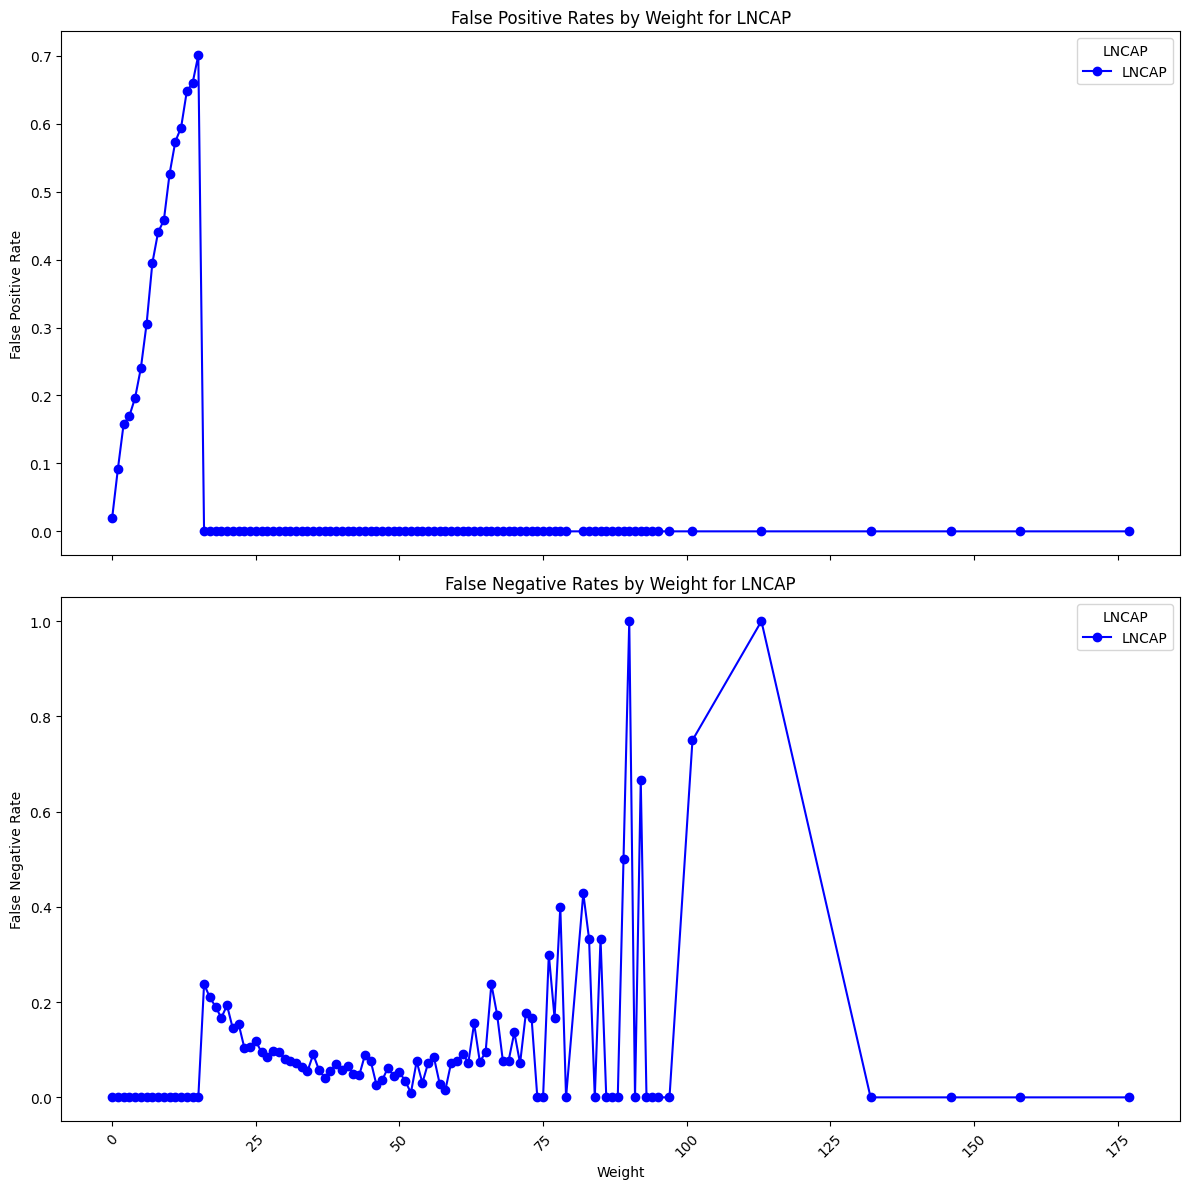

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'correct', 'predicted'
# df = pd.read_csv('your_data.csv')

# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'correct': 'count'})

# Calculate rates
grouped_fp_fn['FP_rate'] = grouped_fp_fn['False_Positive'] / grouped_fp_fn['correct']
grouped_fp_fn['FN_rate'] = grouped_fp_fn['False_Negative'] / grouped_fp_fn['correct']

# Separate LNCAP data
grouped_fp_fn_lncap = grouped_fp_fn.xs('LNCAP', level='cell_line')
grouped_fp_fn_others = grouped_fp_fn.drop('LNCAP', level='cell_line')

# Plotting for all cell lines excluding LNCAP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positive Rates for other cell lines
for cell_line in grouped_fp_fn_others.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn_others.xs(cell_line, level='cell_line')
    axes[0].plot(subset.index, subset['FP_rate'], marker='o', label=cell_line)
axes[0].set_title('False Positive Rates by Weight and Cell Line (excluding LNCAP)')
axes[0].set_ylabel('False Positive Rate')
axes[0].legend(title='Cell Line')

# Plotting False Negative Rates for other cell lines
for cell_line in grouped_fp_fn_others.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn_others.xs(cell_line, level='cell_line')
    axes[1].plot(subset.index, subset['FN_rate'], marker='o', label=cell_line)
axes[1].set_title('False Negative Rates by Weight and Cell Line (excluding LNCAP)')
axes[1].set_ylabel('False Negative Rate')
axes[1].set_xlabel('Weight')
axes[1].legend(title='Cell Line')

# set x ticks to be integers and Rotating x-axis labels for better readability
plt.xticks(rotation=45, ticks=range(0, 3))

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting for LNCAP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positive Rates for LNCAP
axes[0].plot(grouped_fp_fn_lncap.index, grouped_fp_fn_lncap['FP_rate'], marker='o', color='blue', label='LNCAP')
axes[0].set_title('False Positive Rates by Weight for LNCAP')
axes[0].set_ylabel('False Positive Rate')
axes[0].legend(title='LNCAP')

# Plotting False Negative Rates for LNCAP
axes[1].plot(grouped_fp_fn_lncap.index, grouped_fp_fn_lncap['FN_rate'], marker='o', color='blue', label='LNCAP')
axes[1].set_title('False Negative Rates by Weight for LNCAP')
axes[1].set_ylabel('False Negative Rate')
axes[1].set_xlabel('Weight')
axes[1].legend(title='LNCAP')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

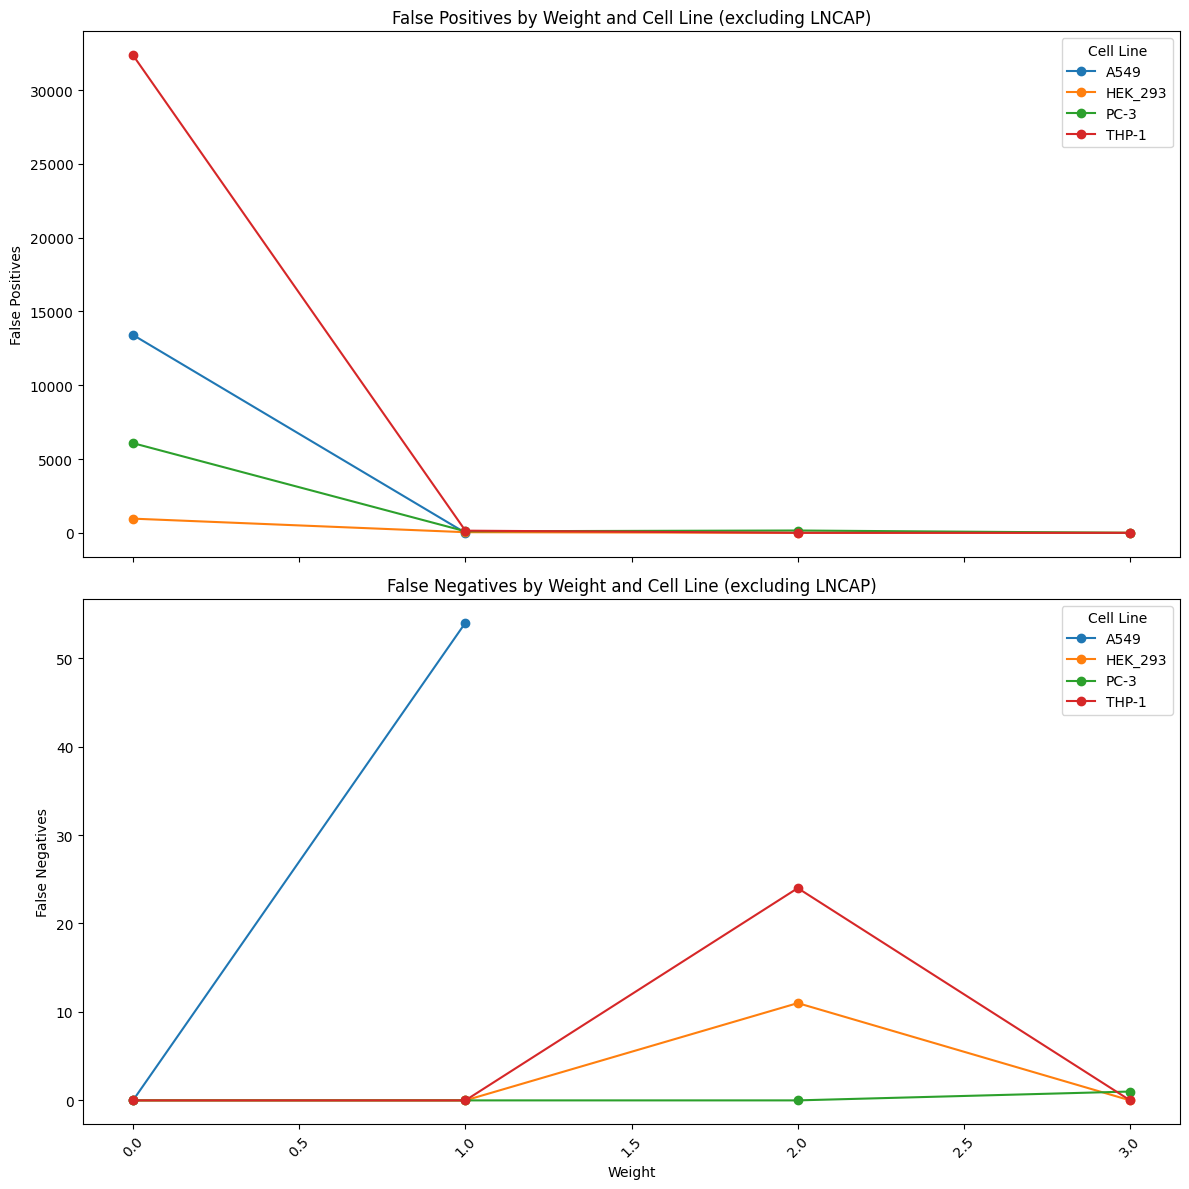

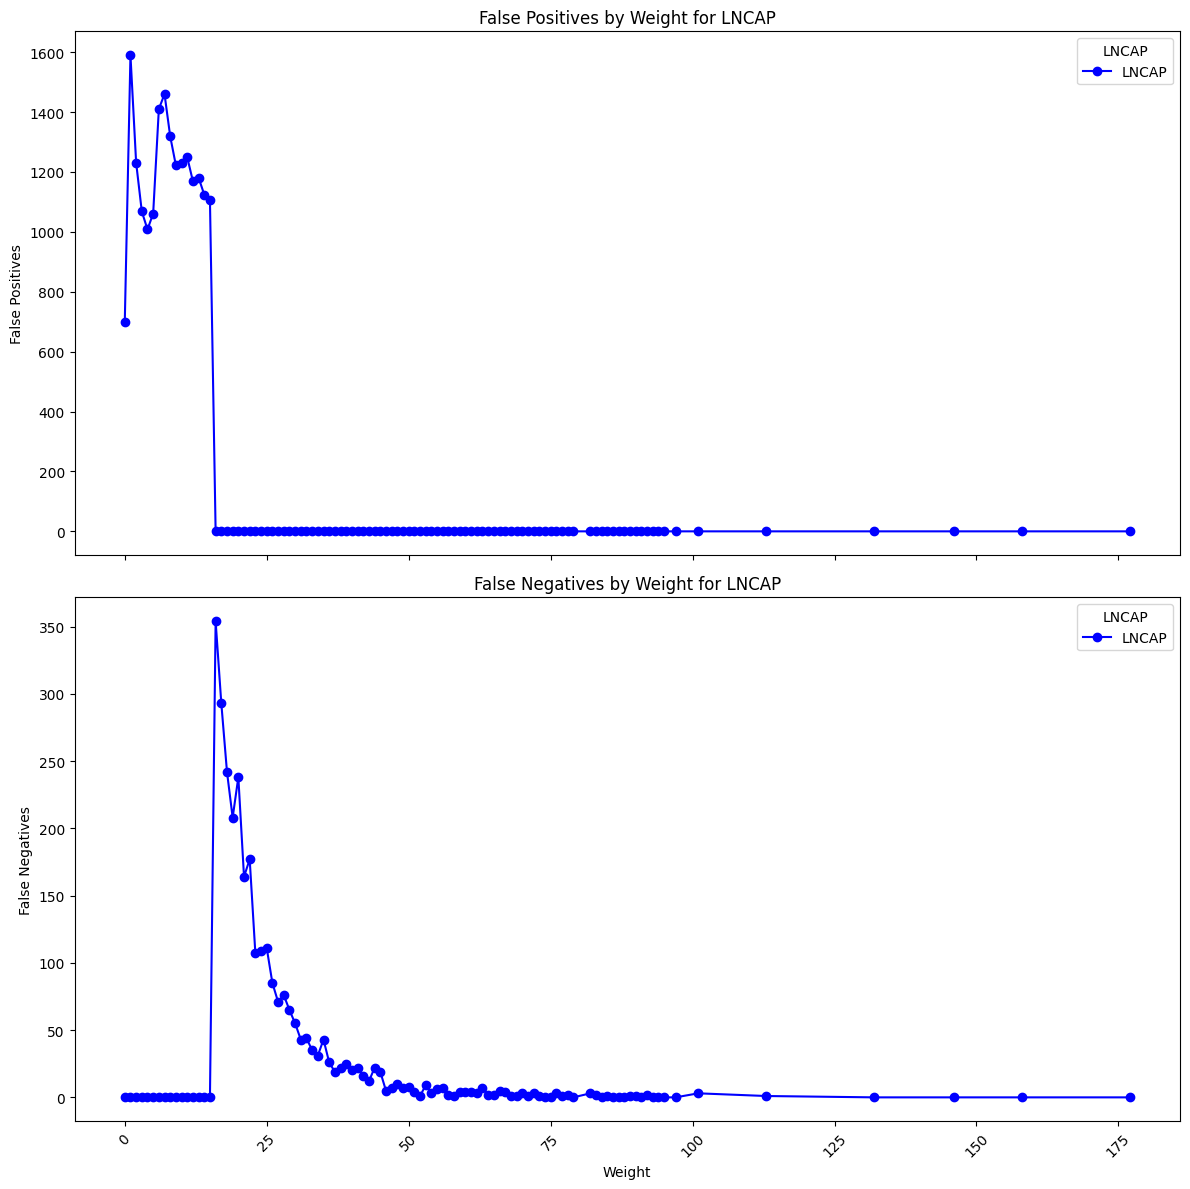

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'correct', 'predicted'
# df = pd.read_csv('your_data.csv')

# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'correct': 'count'})

# Calculate rates
grouped_fp_fn['FP_rate'] = grouped_fp_fn['False_Positive'] / grouped_fp_fn['correct']
grouped_fp_fn['FN_rate'] = grouped_fp_fn['False_Negative'] / grouped_fp_fn['correct']

# Separate LNCAP data
grouped_fp_fn_lncap = grouped_fp_fn.xs('LNCAP', level='cell_line')
grouped_fp_fn_others = grouped_fp_fn.drop('LNCAP', level='cell_line')

# Plotting total number for all cell lines excluding LNCAP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positives for other cell lines
for cell_line in grouped_fp_fn_others.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn_others.xs(cell_line, level='cell_line')
    axes[0].plot(subset.index, subset['False_Positive'], marker='o', label=cell_line)
axes[0].set_title('False Positives by Weight and Cell Line (excluding LNCAP)')
axes[0].set_ylabel('False Positives')
axes[0].legend(title='Cell Line')

# Plotting False Negatives for other cell lines
for cell_line in grouped_fp_fn_others.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn_others.xs(cell_line, level='cell_line')
    axes[1].plot(subset.index, subset['False_Negative'], marker='o', label=cell_line)
axes[1].set_title('False Negatives by Weight and Cell Line (excluding LNCAP)')
axes[1].set_ylabel('False Negatives')
axes[1].set_xlabel('Weight')
axes[1].legend(title='Cell Line')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting total number for LNCAP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positives for LNCAP
axes[0].plot(grouped_fp_fn_lncap.index, grouped_fp_fn_lncap['False_Positive'], marker='o', color='blue', label='LNCAP')
axes[0].set_title('False Positives by Weight for LNCAP')
axes[0].set_ylabel('False Positives')
axes[0].legend(title='LNCAP')

# Plotting False Negatives for LNCAP
axes[1].plot(grouped_fp_fn_lncap.index, grouped_fp_fn_lncap['False_Negative'], marker='o', color='blue', label='LNCAP')
axes[1].set_title('False Negatives by Weight for LNCAP')
axes[1].set_ylabel('False Negatives')
axes[1].set_xlabel('Weight')
axes[1].legend(title='LNCAP')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

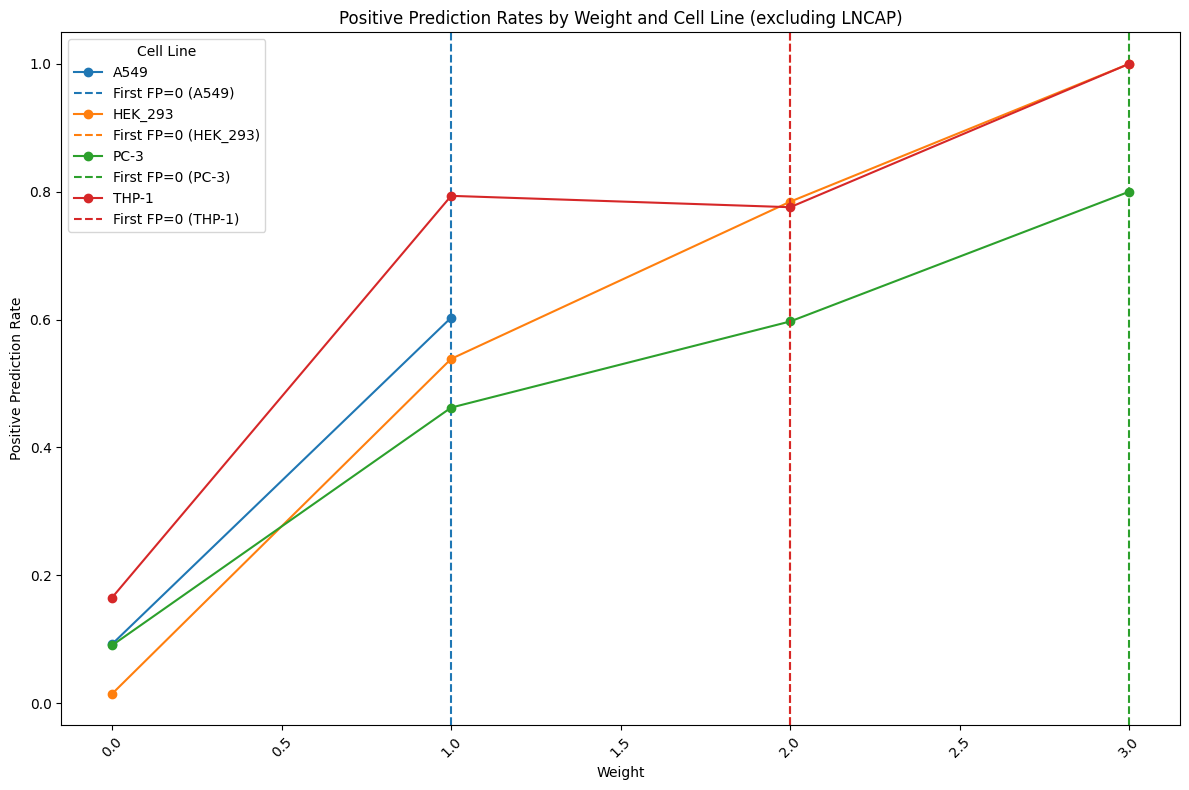

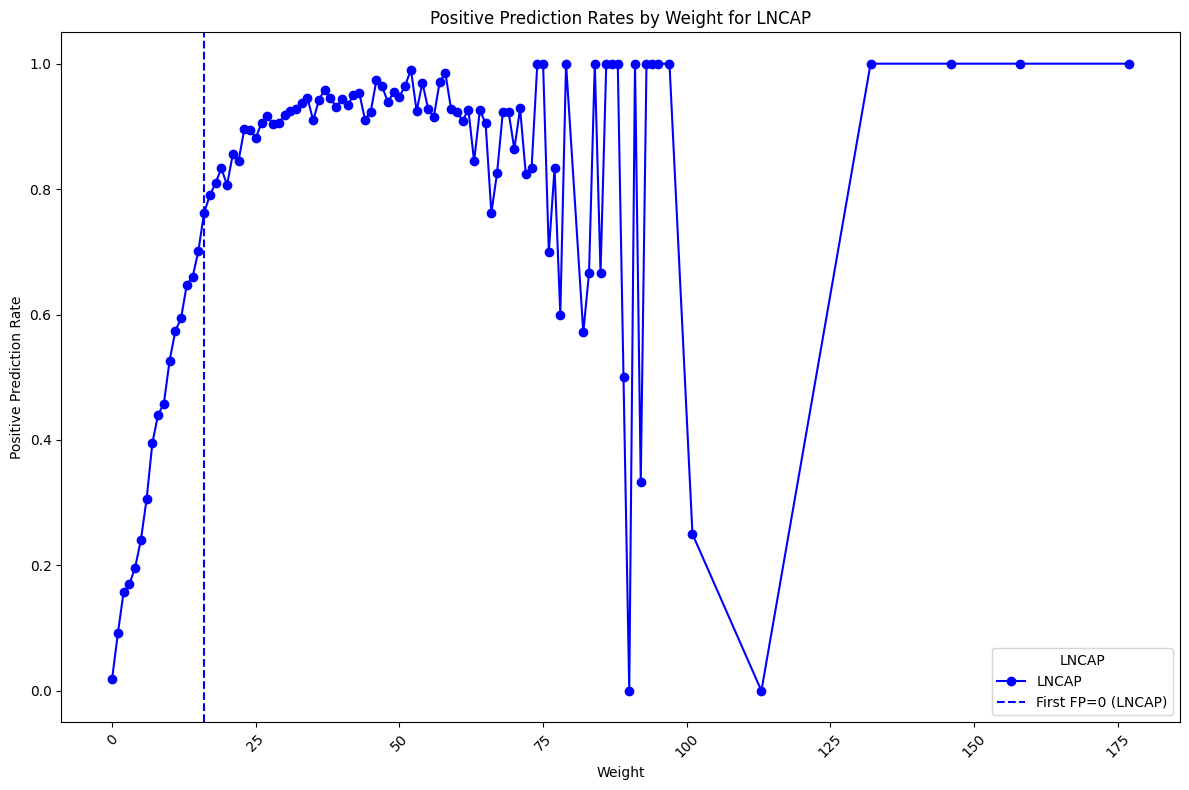

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'correct', 'predicted'
# df = pd.read_csv('your_data.csv')

# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)
df['Positive_Prediction'] = (df['predicted'] == 1).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'Positive_Prediction': 'sum', 'correct': 'count'})

# Calculate rates
grouped_fp_fn['FP_rate'] = grouped_fp_fn['False_Positive'] / grouped_fp_fn['correct']
grouped_fp_fn['FN_rate'] = grouped_fp_fn['False_Negative'] / grouped_fp_fn['correct']
grouped_fp_fn['Positive_Prediction_Rate'] = grouped_fp_fn['Positive_Prediction'] / grouped_fp_fn['correct']

# Separate LNCAP data
grouped_fp_fn_lncap = grouped_fp_fn.xs('LNCAP', level='cell_line')
grouped_fp_fn_others = grouped_fp_fn.drop('LNCAP', level='cell_line')

# Plotting for all cell lines excluding LNCAP
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True)

# Plotting Positive Prediction Rates for other cell lines
colors = plt.cm.tab10.colors  # Use tab10 colormap
color_mapping = {}

for idx, cell_line in enumerate(grouped_fp_fn_others.index.get_level_values('cell_line').unique()):
    # Get min of weight when FP_rate is 0
    subset = grouped_fp_fn_others.xs(cell_line, level='cell_line')
    color = colors[idx % len(colors)]
    color_mapping[cell_line] = color
    ax.plot(subset.index, subset['Positive_Prediction_Rate'], marker='o', label=cell_line, color=color)
    
    # Get min weight when FP_rate is 0
    first_fp_zero_weight = subset[subset['FP_rate'] == 0].index.min()
    if pd.notna(first_fp_zero_weight):
        ax.axvline(first_fp_zero_weight, linestyle='--', color=color, label=f'First FP=0 ({cell_line})')

ax.set_title('Positive Prediction Rates by Weight and Cell Line (excluding LNCAP)')
ax.set_ylabel('Positive Prediction Rate')
ax.set_xlabel('Weight')
ax.legend(title='Cell Line')

# Set x ticks to be integers and rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting for LNCAP
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True)

# Plotting Positive Prediction Rates for LNCAP
ax.plot(grouped_fp_fn_lncap.index, grouped_fp_fn_lncap['Positive_Prediction_Rate'], marker='o', color='blue', label='LNCAP')

# Adding vertical line for first FP=0 for LNCAP
first_fp_zero_weight_lncap = grouped_fp_fn_lncap[grouped_fp_fn_lncap['FP_rate'] == 0].index.min()
if pd.notna(first_fp_zero_weight_lncap):
    ax.axvline(first_fp_zero_weight_lncap, color='blue', linestyle='--', label='First FP=0 (LNCAP)')

ax.set_title('Positive Prediction Rates by Weight for LNCAP')
ax.set_ylabel('Positive Prediction Rate')
ax.set_xlabel('Weight')
ax.legend(title='LNCAP')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()